# 2D Transient Stokes Flow on Open Channel     

##  Import Packages

In [1]:
using BlockArrays
using LinearAlgebra
using UnPack
using LinearSolve 
using SparseArrays
using Ferrite
using FerriteGmsh 
using OrdinaryDiffEq
using DifferentialEquations
using Plots 
using WriteVTK

## Section 1: Introduction 

### Section 1.1: Goals 

The <b>goals</b> of this notebook is to provide more guidelines in solving Stokes (now and Navier-Stokes flow later) using [Ferrite.jl](). We hope to use these guidelines is tackling future applications. 

### Section 2.1: Test Cases 

We consider solving Stokes flow in a classical test case of a rectangular horizontal channel (or pipe). As boundary conditions, we impose on the inlet patch inlet conditions for the velocity, on the bottom and top wall path we impose no-slip boundary conditions for the velocity and on the outldet patch we impose a value for the pressure. (The case of zero mean pressure is left for future work). We consider one stationary and two transient cases. In both transient cases, we aim at recovering the stationary solution. In the first transient case (Transient-Case-1), we impose the stationary solution as initial guess and <b>do not</b> ramp the inlet conditions. In the second transient case (Transient-Case-2), we impose the zero solution as initial guess and <b>do ramp</b> the inlet conditions. The transient cases are solved using both a hand-coded time-stepping as well as using DifferentialEquations.jl. 

### Section 3.1: Implementation Details: Hand-Coded Time Stepping in Transient-Case-1 (without ramping)

<b>Handling the Dirichtlet Boundary Conditions</b>
1. (constraint handler): no need to update the constraint handler (using update!(ch,t)). But does not hurt to do so; 
1. (time-stepping matrix): prior to the stepping loop, an implicit Euler time-stepping matrix $A$ is formed. Solving a linear system with $A$ at each time step, requires adapting $A$ to the boundary conditions. Therefore the call apply!(A,ch) is acquired. <i>Question:</i> does the result of apply!(A,ch) change with time $t$ in Transient-case-2? This question is relevant in solving using DifferentialEquations.jl; 
1. (right-hand side vector): update the right-hand side vector to take previous time-step into account;   
1. (solution vector): the solution vector is not updated with boundary conditions in hand-coded time stepping; 

### Section 4.1: Implementation Details: Hand-Coded Time Stepping in Transient-Case-2 (with ramping)

<b>Handling the Dirichtlet Boundary Conditions</b>
1. (constraint handler): need to update the constraint handler (using update!(ch,t)) to update to ramping; 
1. (time-stepping matrix): as before;  
1. (right-hand side vector): as before;   
1. (solution vector): as before;
 
### Section 5.1: Implementation Details: Time Stepping Using DifferentialEquations.jl in Transient-Case-1

<b>Applying the Dirichlet boundary conditions to the Stiffness Matrix</b>
Updated to the constraints prior to time-stepping. Why? 

<b>Applying the Dirichlet boundary conditions to the Mass Matrix</b>
Updated to the constraints prior to time-stepping. Not sure to what extend this is required. 

<b>Applying the Dirichlet boundary conditions to the Jacobian</b>
1. omitting the Jacobian lead to problem that Jacobian cannot be generated using automatic differention. Analytical Jacobian needs to be supplied;
2. omitting the argumennt jac_prototype is such that the Jacobian J fails to be recognized as sparse and the call nonzeros(J) fails due to a method error;
3. in the construction of the Jacobian, the function apply!(J,ch) is called to elimiated the constrained dofs from the Jacobian. This is done to decouple the constrained dofs in the nonlinear solver from the remaining system;
4. we simplified the code for the Jacobian further to construct the Jacobian prior to the time-stepping loop;

### Section 6.1: Implementation Details: Time Stepping Using DifferentialEquations.jl in Transient-Case-2 

<b>Time Integration Methods</b>
1. are explicit time integration methods for DAE systems (to avoid the singularity in the linear solve issue). Explicit Euler fails; 

More later.

## Section 2: Auxilary Post-Processing Function  

In [2]:
function mypostprocess(u, dh)
 
    area = [] 
    velx = [] 
    vely = []
    pres = []

    for (cell_num, cell) in enumerate(CellIterator(dh))

        dof_range_u = dof_range(dh,:u)
        dof_range_p = dof_range(dh,:p)
        uloc = u[celldofs(dh,cell_num)[dof_range_u]]
        ploc = u[celldofs(dh,cell_num)[dof_range_p]]
        Ferrite.reinit!(cvu, cell)

        cellarea = 0. 
        cellvelocity = [0.,0.]
        cellpressure = 0 
    
        for q_point in 1:getnquadpoints(cvu)
            dΩ = getdetJdV(cvu, q_point)
            velocity = function_value(cvu, q_point, uloc)
            cellarea += dΩ 
            cellvelocity += velocity*dΩ
        end

        for q_point in 1:getnquadpoints(cvp)
            dΩ = getdetJdV(cvp, q_point)
            pressure = function_value(cvp, q_point, ploc)
            cellpressure += pressure*dΩ
        end

        append!(area, cellarea)
        append!(velx, cellvelocity[1]) 
        append!(vely, cellvelocity[2])
        append!(pres, cellpressure)
    
    end  

    velx2d = reshape(velx, nels)
    vely2d = reshape(vely, nels)
    pres2d = reshape(pres, nels)
    
    return area, velx2d, vely2d, pres2d  
end 

mypostprocess (generic function with 1 method)

## Section 3: Generate 2D Mesh 

In [3]:
nels  = (20, 5) # number of elements in each spatial direction
left  = Vec((0., 0.))    # start point for geometry 
right = Vec((1.0, 0.25,)) # end point for geometry
grid = generate_grid(Quadrilateral,nels,left,right);

In [4]:
addvertexset!(grid, "corner", (x) -> x[1] ≈ 0.0 && x[2] ≈ 0.0)

Grid{2, Quadrilateral, Float64} with 100 Quadrilateral cells and 126 nodes

In [5]:
getvertexset(grid, "corner")

OrderedCollections.OrderedSet{VertexIndex} with 1 element:
  VertexIndex((1, 1))

## Section 4: Functions for Assembly of Stiffness Matrix and Load Vector 
Modified tutorial by removing the volumetric source term. 

In [6]:
function assemble_mass_matrix!(cellvalues_v::CellValues, cellvalues_p::CellValues, M::SparseMatrixCSC, dh::DofHandler)
    # Allocate a buffer for the local matrix and some helpers, together with the assembler.
    n_basefuncs_v = getnbasefunctions(cellvalues_v)
    n_basefuncs_p = getnbasefunctions(cellvalues_p)
    n_basefuncs = n_basefuncs_v + n_basefuncs_p
    v▄, p▄ = 1, 2
    Mₑ = BlockedArray(zeros(n_basefuncs, n_basefuncs), [n_basefuncs_v, n_basefuncs_p], [n_basefuncs_v, n_basefuncs_p])

    # It follows the assembly loop as explained in the basic tutorials.
    mass_assembler = start_assemble(M)
    for cell in CellIterator(dh)
        fill!(Mₑ, 0)
        Ferrite.reinit!(cellvalues_v, cell)

        for q_point in 1:getnquadpoints(cellvalues_v)
            dΩ = getdetJdV(cellvalues_v, q_point)
            # Remember that we assemble a vector mass term, hence the dot product.
            # There is only one time derivative on the left hand side, so only one mass block is non-zero.
            for i in 1:n_basefuncs_v
                φᵢ = shape_value(cellvalues_v, q_point, i)
                for j in 1:n_basefuncs_v
                    φⱼ = shape_value(cellvalues_v, q_point, j)
                    Mₑ[BlockIndex((v▄, v▄), (i, j))] += φᵢ ⋅ φⱼ * dΩ
                end
            end
        end
        assemble!(mass_assembler, celldofs(cell), Mₑ)
    end

    return M
end

function assemble_stokes_matrix!(K, dh, cvu, cvp, viscosity)
    assembler = start_assemble(K)
    ke = zeros(ndofs_per_cell(dh), ndofs_per_cell(dh))
    range_u = dof_range(dh, :u)
    ndofs_u = length(range_u)
    range_p = dof_range(dh, :p)
    ndofs_p = length(range_p)
    ϕᵤ = Vector{Vec{2,Float64}}(undef, ndofs_u)
    ∇ϕᵤ = Vector{Tensor{2,2,Float64,4}}(undef, ndofs_u) # 2-by-2 tensor 
    divϕᵤ = Vector{Float64}(undef, ndofs_u)
    ϕₚ = Vector{Float64}(undef, ndofs_p)
    for cell in CellIterator(dh)
        Ferrite.reinit!(cvu, cell)
        Ferrite.reinit!(cvp, cell)
        ke .= 0
        for qp in 1:getnquadpoints(cvu)
            dΩ = getdetJdV(cvu, qp)
            for i in 1:ndofs_u
                ϕᵤ[i] = shape_value(cvu, qp, i)
                ∇ϕᵤ[i] = shape_gradient(cvu, qp, i)
                divϕᵤ[i] = shape_divergence(cvu, qp, i)
            end
            for i in 1:ndofs_p
                ϕₚ[i] = shape_value(cvp, qp, i)
            end
            # u-u
            for (i, I) in pairs(range_u), (j, J) in pairs(range_u)
                ke[I, J] += viscosity*( ∇ϕᵤ[i] ⊡ ∇ϕᵤ[j] ) * dΩ
            end
            # u-p
            for (i, I) in pairs(range_u), (j, J) in pairs(range_p)
                ke[I, J] += ( -divϕᵤ[i] * ϕₚ[j] ) * dΩ
            end
            # p-u
            for (i, I) in pairs(range_p), (j, J) in pairs(range_u)
                ke[I, J] += ( -divϕᵤ[j] * ϕₚ[i] ) * dΩ
            end
        end
        assemble!(assembler, celldofs(cell), ke)
    end
    return K 
end

function setup_mean_constraint(dh, fvp)
    assembler = Ferrite.COOAssembler()
    # All external boundaries
    set = union(
            getfacetset(dh.grid, "left"),
            getfacetset(dh.grid, "right"),
            getfacetset(dh.grid, "bottom"),
            getfacetset(dh.grid, "top"),
    )
    # Allocate buffers
    range_p = dof_range(dh, :p)
    element_dofs = zeros(Int, ndofs_per_cell(dh))
    element_dofs_p = view(element_dofs, range_p)
    element_coords = zeros(Vec{2}, 4) # assuming 2D mesh with quadrilaterals only 
    Ce = zeros(1, length(range_p)) # Local constraint matrix (only 1 row)
    # Loop over all the boundaries
    for (ci, fi) in set
        Ce .= 0
        getcoordinates!(element_coords, dh.grid, ci)
        Ferrite.reinit!(fvp, element_coords, fi)
        celldofs!(element_dofs, dh, ci)
        for qp in 1:getnquadpoints(fvp)
            dΓ = getdetJdV(fvp, qp)
            for i in 1:getnbasefunctions(fvp)
                Ce[1, i] += shape_value(fvp, qp, i) * dΓ
            end
        end
        # Assemble to row 1
        assemble!(assembler, [1], element_dofs_p, Ce)
    end
    C, _ = finish_assemble(assembler)
    # Create an AffineConstraint from the C-matrix
    _, J, V = findnz(C)
    _, constrained_dof_idx = findmax(abs2, V)
    constrained_dof = J[constrained_dof_idx]
    V ./= V[constrained_dof_idx]
    mean_value_constraint = AffineConstraint(
        constrained_dof,
        Pair{Int,Float64}[J[i] => -V[i] for i in 1:length(J) if J[i] != constrained_dof],
        0.0,
    )

    return mean_value_constraint
end

setup_mean_constraint (generic function with 1 method)

## Section 5: Open Channel: Set-up, Assembly and Solve

In [7]:
nelem = 10 # 20
H = 0.25; L = 4*H 
nels  = (4*nelem, nelem) # number of elements in each spatial direction
left  = Vec((0., 0.))    # start point for geometry 
right = Vec((L, H,)) # end point for geometry
grid = generate_grid(Quadrilateral,nels,left,right);
addvertexset!(grid, "corner", (x) -> x[1] ≈ 0.0 && x[2] ≈ 0.0)

dim = 2 
degree = 1

# Interpolations
ipu = Lagrange{RefQuadrilateral,degree+1}() ^ dim # quadratic for 2 velocity components 
ipp = Lagrange{RefQuadrilateral,degree}()         # linear for scalar pressure 

# Dofs
dh = DofHandler(grid)
add!(dh, :u, ipu)
add!(dh, :p, ipp)
close!(dh) 

# FE values
qr = QuadratureRule{RefQuadrilateral}(2*degree+1)
ipg = Lagrange{RefQuadrilateral,1}() # linear geometric interpolation
cvu = CellValues(qr, ipu, ipg) # observe three arguments - need to document whether this is required 
cvp = CellValues(qr, ipp, ipg) # observe three arguments - need to document whether this is required

# Boundary conditions 
ch = ConstraintHandler(dh)

vmax = 1. # amplitude of velocity inflow profile 
vin(t) = vmax # Transient-Case1: no ramping in time
vin(t) = min(t * vmax, vmax) # Transient-Case2: with ramping in time
parabolic_inflow_profile(x,t) = Vec((vin(t)*x[2]*(H-x[2])/(H^2/4), 0.0))

# Boundary conditions part (1/3): Dirichlet BC for the velocity at the top lid 
inlet = getfacetset(dh.grid, "left")
dbc1 = Dirichlet(:u, inlet, (x,t) ->  parabolic_inflow_profile(x,t) )
add!(ch, dbc1)

# Boundary conditions part (2/3): no slip boundary condition - impose velocity to be zero vector on the walls   
wall = union(
    getfacetset(grid, "top"),
    getfacetset(grid, "bottom"),
)
dbc2 = Dirichlet(:u, wall, (x, t) -> [0, 0])
add!(ch, dbc2)
    
# Boundary conditions part (3/3): apply pressure constraint
outlet = getfacetset(dh.grid, "right")
dbc3 = Dirichlet(:p, outlet, (x, t) -> 0)
add!(ch, dbc3)
    
# Finalize
close!(ch)

# Global tangent matrix and rhs
coupling = [true true; true false] # no coupling between pressure test/trial functions
#coupling = [true true; true true] # no coupling between pressure test/trial functions
K = allocate_matrix(dh, ch; coupling=coupling)
f = zeros(ndofs(dh))

# Assemble system
viscosity = 1e3
assemble_stokes_matrix!(K, dh, cvu, cvp, viscosity); 

# Apply boundary conditions and solve
update!(ch, 2.)
apply!(K, f, ch)
update!(ch, 0.)
u = K \ f;
ustationary = u 

VTKGridFile("init_stokes_2d_channel", dh) do vtk
    write_solution(vtk, dh, u)
    Ferrite.write_constraints(vtk, ch)
end

VTKGridFile for the closed file "init_stokes_2d_channel.vtu".

### Section 1.5: Plot the inlet condition as verification 

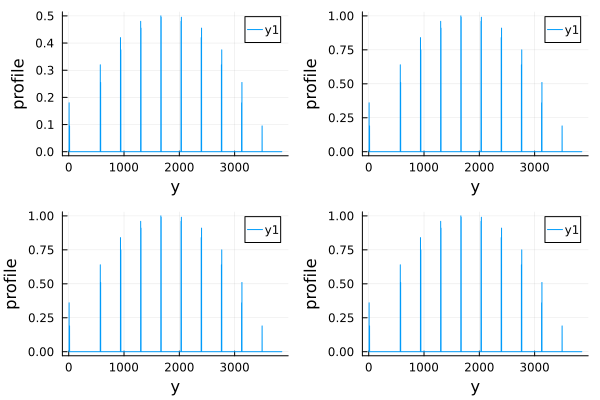

In [8]:
utest = zeros(ndofs(dh))
update!(ch, .5)
apply!(utest,ch)
p1=plot(utest,xlabel="y",ylabel="profile")
utest = zeros(ndofs(dh))
update!(ch, 1)
apply!(utest,ch)
p2 = plot(utest,xlabel="y",ylabel="profile")
utest = zeros(ndofs(dh))
update!(ch, 1.5)
apply!(utest,ch)
p3 = plot(utest,xlabel="y",ylabel="profile")
utest = zeros(ndofs(dh))
update!(ch, 2)
apply!(utest,ch)
p4 = plot(utest,xlabel="y",ylabel="profile")
plot(p1,p2,p3,p4,layout=(2,2))

## Section 6: Plot Stationary Velocity and Pressure by Hand-Coded Post-Processing 

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


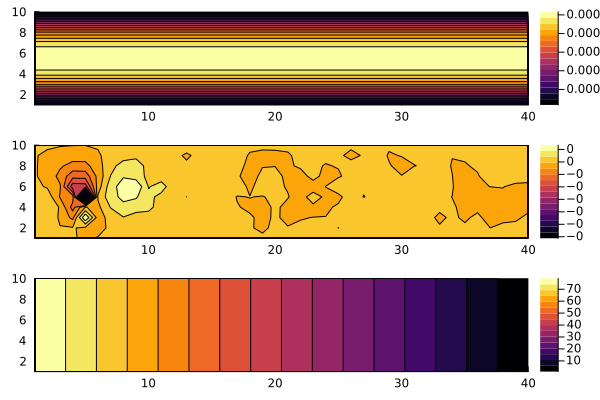

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


In [9]:
area, velx2d, vely2d, pres2d = mypostprocess(u, dh) 
p1 = contour(velx2d', fill=true)
p2 = contour(vely2d', fill=true)
p3 = contour(pres2d', fill=true)
plot(p1,p2,p3,layout=(3,1))

## Section 7: Closed Vesel  

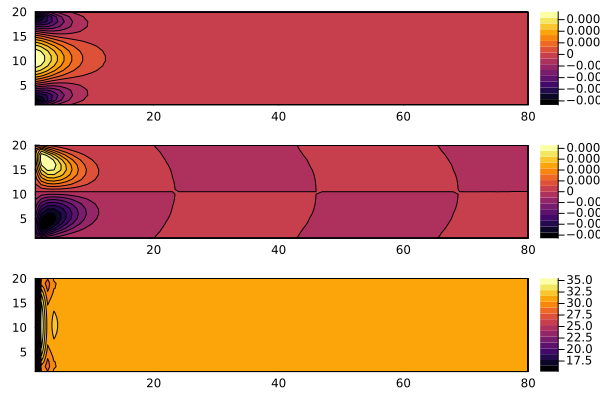

In [25]:
nelem = 20 # 20
H = 0.25; L = 4*H 
nels  = (4*nelem, nelem) # number of elements in each spatial direction
left  = Vec((0., 0.))    # start point for geometry 
right = Vec((L, H,)) # end point for geometry
grid = generate_grid(Quadrilateral,nels,left,right);
addvertexset!(grid, "corner", (x) -> x[1] ≈ 0.0 && x[2] ≈ 0.0)

dim = 2 
degree = 1

# Interpolations
ipu = Lagrange{RefQuadrilateral,degree+1}() ^ dim # quadratic for 2 velocity components 
ipp = Lagrange{RefQuadrilateral,degree}()         # linear for scalar pressure 

# Dofs
dh = DofHandler(grid)
add!(dh, :u, ipu)
add!(dh, :p, ipp)
close!(dh) 

# FE values
qr = QuadratureRule{RefQuadrilateral}(2*degree+1)
ipg = Lagrange{RefQuadrilateral,1}() # linear geometric interpolation
cvu = CellValues(qr, ipu, ipg) # observe three arguments - need to document whether this is required 
cvp = CellValues(qr, ipp, ipg) # observe three arguments - need to document whether this is required
qr_facet = FacetQuadratureRule{RefQuadrilateral}(2)
fvp = FacetValues(qr_facet, ipp, ipg) # buffer to integrate over facets - required for pressure constraint 

# Boundary conditions 
ch = ConstraintHandler(dh)

vmax = 1. # amplitude of velocity inflow profile 
vin(t) = vmax # Transient-Case1: no ramping in time
vin(t) = min(t * vmax, vmax) # Transient-Case2: with ramping in time
parabolic_inflow_profile(x,t) = Vec((vin(t)*x[2]*(H-x[2])/(H^2/4), 0.0))

# Boundary conditions part (1/3): Dirichlet BC for the velocity at the top lid 
inlet = getfacetset(dh.grid, "left")
dbc1 = Dirichlet(:u, inlet, (x,t) ->  parabolic_inflow_profile(x,t) )
add!(ch, dbc1)

# Boundary conditions part (2/3): no slip boundary condition - impose velocity to be zero vector on the walls   
wall = union(
    getfacetset(grid, "top"),
    getfacetset(grid, "right"),
    getfacetset(grid, "bottom"),
)
dbc2 = Dirichlet(:u, wall, (x, t) -> [0, 0])
add!(ch, dbc2)

# Boundary conditions part (3/3): apply pressure constraint
# mean_value_constraint = setup_mean_constraint(dh, fvp)
# add!(ch, mean_value_constraint) 
#corner_patch = getvertexset(grid, "corner")
#dbc3 = Dirichlet(:p, corner_patch, (x, t) -> 0)
dbc3 = Dirichlet(:p, inlet, (x,t) ->  0 )
add!(ch, dbc3)

# Finalize
close!(ch)

# Global tangent matrix and rhs
coupling = [true true; true false] # no coupling between pressure test/trial functions
#coupling = [true true; true true] # no coupling between pressure test/trial functions
K = allocate_matrix(dh, ch; coupling=coupling)
f = zeros(ndofs(dh))

# Assemble system
viscosity = 1e3
assemble_stokes_matrix!(K, dh, cvu, cvp, viscosity); 

# Apply boundary conditions and solve
update!(ch, 2.)
apply!(K, f, ch)
update!(ch, 0.)
u = K \ f

area, velx2d, vely2d, pres2d = mypostprocess(u, dh) 
p1 = contour(velx2d', fill=true)
p2 = contour(vely2d', fill=true)
p3 = contour(pres2d', fill=true)
plot(p1,p2,p3,layout=(3,1))

In [26]:
fvp

FacetValues(scalar, rdim=2, sdim=2): 2 quadrature points per facet
 Function interpolation: Lagrange{RefQuadrilateral, 1}()
Geometric interpolation: Lagrange{RefQuadrilateral, 1}()^2

## Section 8: Hand-Coded Time Stepping (can be simplified for Transient-Case-1)

In [10]:
# allocate, assemble and apply bc to mass matrix 
M = allocate_matrix(dh,ch);
M = assemble_mass_matrix!(cvu, cvp, M, dh);

# allocate and assemble the stiffness matrix 
K = allocate_matrix(dh,ch);
viscosity = 1e3
K = assemble_stokes_matrix!(K, dh, cvu, cvp, viscosity);
f = zeros(ndofs(dh));

In [11]:
# set time constants 
T  = 2.0
dt = 1e-1

A = copy(M)
A.nzval .= M.nzval .+ dt .* K.nzval

rhsdata = get_rhs_data(ch, A);

# set initial guess 
un = zeros(length(f));
# un = ustationary 

# apply boundary conditions 
apply!(A, ch);

pvd = paraview_collection("stokes-transient")
VTKGridFile("stokes-transient-0", dh) do vtk
    write_solution(vtk, dh, un)
    pvd[0.0] = vtk
end

for (step, t) in enumerate(dt:dt:T)
    display(t)
    
    #..(1/6) update the Dirichlet boundary condition values.
    update!(ch, t)

    #..(2/6) compute the right-hand-side of the problem.
    b = dt .* f .+ M * un
    
    #..(3/6) apply the boundary conditions of the current time step.
    apply_rhs!(rhsdata, b, ch)

    #..(4/6) solve the time step 
    u = A \ b

    #..(5/6) save the solution
    VTKGridFile("stokes-transient-$step", dh) do vtk
        write_solution(vtk, dh, u)
        pvd[t] = vtk
    end
    
    #..(6/6) set the previous solution to the current one and go to the next time step.
    un .= u
end

vtk_save(pvd);

0.1

0.2

0.3

0.4

0.5

0.6

0.7

0.8

0.9

1.0

1.1

1.2

1.3

1.4

1.5

1.6

1.7

1.8

1.9

2.0

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


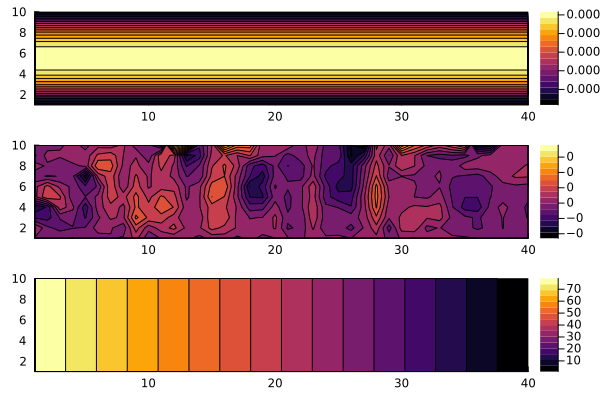

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


In [12]:
# post-process solution 
area, velx2d, vely2d, pres2d = mypostprocess(un, dh) 
p1 = contour(velx2d', fill=true)
p2 = contour(vely2d', fill=true)
p3 = contour(pres2d', fill=true)
plot(p1,p2,p3,layout=(3,1))

## Section 9: Extension of Hand-Code Transient Loop to the Non-Linear Case 
To be extended to non-linear equations on the boundary. 
1. non-linear residual (similar to traction forces in linear elasticity tutorial); 
3. Jacobian matching with linear equations on the boundary
4. zero-velocity initial guess; 

In [37]:
inlet

OrderedCollections.OrderedSet{FacetIndex} with 20 elements:
  FacetIndex((1, 4))
  FacetIndex((81, 4))
  FacetIndex((161, 4))
  FacetIndex((241, 4))
  FacetIndex((321, 4))
  FacetIndex((401, 4))
  FacetIndex((481, 4))
  FacetIndex((561, 4))
  FacetIndex((641, 4))
  FacetIndex((721, 4))
  FacetIndex((801, 4))
  FacetIndex((881, 4))
  FacetIndex((961, 4))
  FacetIndex((1041, 4))
  FacetIndex((1121, 4))
  FacetIndex((1201, 4))
  FacetIndex((1281, 4))
  FacetIndex((1361, 4))
  FacetIndex((1441, 4))
  FacetIndex((1521, 4))

In [38]:
function assemble_external_forces!(f_ext, dh, facetset, facetvalues, prescribed_traction)
    # Create a temporary array for the facet's local contributions to the external force vector
    fe_ext = zeros(getnbasefunctions(facetvalues))
    for facet in FacetIterator(dh, facetset)
        # Update the facetvalues to the correct facet number
        reinit!(facetvalues, facet)
        # Reset the temporary array for the next facet
        fill!(fe_ext, 0.0)
        # Access the cell's coordinates
        cell_coordinates = getcoordinates(facet)
        for qp in 1:getnquadpoints(facetvalues)
            # Calculate the global coordinate of the quadrature point.
            x = spatial_coordinate(facetvalues, qp, cell_coordinates)
            tₚ = prescribed_traction(x)
            # Get the integration weight for the current quadrature point.
            dΓ = getdetJdV(facetvalues, qp)
            for i in 1:getnbasefunctions(facetvalues)
                Nᵢ = shape_value(facetvalues, qp, i)
                fe_ext[i] += tₚ ⋅ Nᵢ * dΓ
            end
        end
        # Add the local contributions to the correct indices in the global external force vector
        assemble!(f_ext, celldofs(facet), fe_ext)
    end
    return f_ext
end

function compute_bfield(cellvalues::CellScalarValues{dim,T}, dh::DofHandler, a) where {dim,T}

    n = getnbasefunctions(cellvalues)
    cell_dofs = zeros(Int, n)
    nqp = getnquadpoints(cellvalues)

    # Allocate storage for the fluxes to store
    q = [Vec{2,T}[] for _ in 1:getncells(dh.grid)]

    for (cell_num, cell) in enumerate(CellIterator(dh))
        q_cell = q[cell_num]
        celldofs!(cell_dofs, dh, cell_num)
        aᵉ = a[cell_dofs]
        reinit!(cellvalues, cell)
        coords = getcoordinates(cell)
        
        for q_point in 1:nqp
            coords_qp = spatial_coordinate(cellvalues, q_point, coords)
            val_diff_coeff = my_diff_coeff(coords_qp)
            q_qp = - val_diff_coeff*function_gradient(cellvalues, q_point, aᵉ)
            push!(q_cell, q_qp)
        end
    end
    return q
end

function inlet_residual!(r, dh, facetset, facetvalues)
    # Q: how to form p_static + \vector{u} \cdot \vector{u} on a facet of the inlet patch? 
    # A: given a (facetIndex, cellIndex) pair belonging to the inlet patch and given the global pressure-velocity solution vector,
    #    one is able to reconstruct the pressure and velocity approximation in every quadrature point of the cell
    #    and thus integrate a functional of thew pressure-velocity on the boundary of the cell  
    # Create a temporary array for the facet's local contributions to the external force vector
    re = zeros(ndofs_per_cell(dh))
    for facet in FacetIterator(dh, facetset)
        # Update the facetvalues to the correct facet number
        Ferrite.reinit!(facetvalues, facet)
        # Reset the temporary array for the next facet
        fill!(re, 0.0)
        # Access the cell's coordinates
        cell_coordinates = getcoordinates(facet)
        for qp in 1:getnquadpoints(facetvalues)
            # Calculate the global coordinate of the quadrature point.
            x = spatial_coordinate(facetvalues, qp, cell_coordinates)
            # Get the integration weight for the current quadrature point.
            dΓ = getdetJdV(facetvalues, qp)
            for i in 1:getnbasefunctions(facetvalues)
                Nᵢ = shape_value(facetvalues, qp, i)
            end
        end
        # Add the local contributions to the correct indices in the global external force vector
        assemble!(r, celldofs(facet), re)
    end
    return r
end

inlet_residual! (generic function with 1 method)

In [33]:
r = zeros(ndofs(dh)); 
r = inlet_residual!(r,dh,inlet,fvp)

14903-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

## Section 10: Time Integration of the Stokes System Using DifferentialEquations.jl

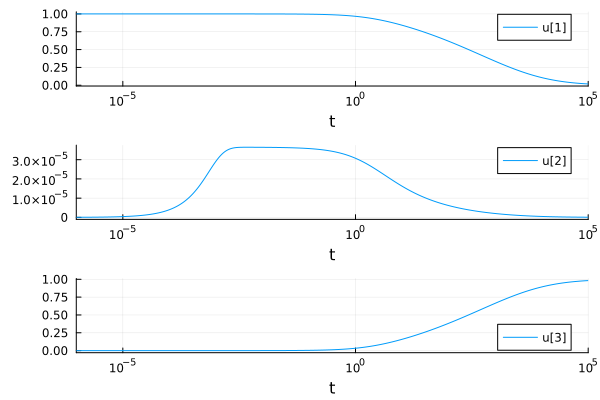

In [111]:
function rober(du, u, p, t)
    y₁, y₂, y₃ = u
    k₁, k₂, k₃ = p
    du[1] = -k₁ * y₁ + k₃ * y₂ * y₃
    du[2] = k₁ * y₁ - k₃ * y₂ * y₃ - k₂ * y₂^2
    du[3] = y₁ + y₂ + y₃ - 1
    nothing
end
M = [1.0 0 0
     0 1.0 0
     0 0 0]
f = ODEFunction(rober, mass_matrix = M)
prob_mm = ODEProblem(f, [1.0, 0.0, 0.0], (0.0, 1e5), (0.04, 3e7, 1e4))
sol = solve(prob_mm, Rodas5(), reltol = 1e-8, abstol = 1e-8)

plot(sol, xscale = :log10, tspan = (1e-6, 1e5), layout = (3, 1))

In [13]:
#..pass data to RHS of time integration 
struct RHSparams
    K::SparseMatrixCSC
    J::SparseMatrixCSC
    ch::ConstraintHandler
    u::Vector
end 

# one is **not** allowed to mutate the input argument of the function stokes!() 
# therefore the state vector u is fetched from the input parameters 
# this state vector u is updated with boundary conditions  
function stokes!(du, u_uc, p::RHSparams, t)

    display(t)
    
    @unpack K, J, ch, u = p
    
    u .= u_uc
    update!(ch, t)
    apply!(u, ch)
    
    # Linear contribution (Stokes operator)
    mul!(du, K, u) # du .= K * u

    return
end

# merely return the Jacobian being passed in 
# the boundary conditions are applied prior to the time-stepping loop  
function stokes_jac!(J, u_uc, p::RHSparams, t)

    @unpack K, J, ch, u = p
        
    return J  
end

# applies velocity and pressure boundary conditions
function ferrite_limiter!(u, _, p, t)
    update!(p.ch, t)
    return apply!(u, p.ch)
end

struct FreeDofErrorNorm
    ch::ConstraintHandler
end
(fe_norm::FreeDofErrorNorm)(u::Union{AbstractFloat, Complex}, t) = DiffEqBase.ODE_DEFAULT_NORM(u, t)
(fe_norm::FreeDofErrorNorm)(u::AbstractArray, t) = DiffEqBase.ODE_DEFAULT_NORM(u[fe_norm.ch.free_dofs], t)

timestepper = Rodas5P(autodiff = false, step_limiter! = ferrite_limiter!)

# set time constants 
T   = 2.0 
Δt₀ = 0.1

# allocate, assemble and apply bc to mass matrix 
M = allocate_matrix(dh);
M = assemble_mass_matrix!(cvu, cvp, M, dh);
apply!(M, ch) # required as linear systems with matrix M are solved 

# allocate and assemble the stiffness matrix 
K = allocate_matrix(dh);
viscosity = 1e3
K = assemble_stokes_matrix!(K, dh, cvu, cvp, viscosity)
# apply!(K, ch) # left out as **no** linear systems with matrix K are solved

# create Jacobian and its sparsity pattern 
J = copy(K)
apply!(J, ch)
jac_sparsity = sparse(J);

# set initial guess 
# uinit = ustationary # Transient-Case1: no ramping in time 
uinit = zeros(ndofs(dh)); update!(ch,0); apply!(uinit, ch); # Transient-Case2: with ramping in time 

# set parameters 
p = RHSparams(K, J, ch, copy(uinit))

rhs = ODEFunction(stokes!, mass_matrix = M; jac = stokes_jac!, jac_prototype = jac_sparsity)

problem = ODEProblem(rhs, uinit, (0.0, T), p);

sol = solve(problem, timestepper; initializealg = NoInit(), dt = Δt₀,
            adaptive = true, abstol = 1.0e-4, reltol = 1.0e-5,
            progress = true, progress_steps = 1,
            verbose = true, internalnorm = FreeDofErrorNorm(ch), d_discontinuities = [1.0]
           )

0.0

1.4901161193847656e-8

0.0

0.06358126895828704

0.04095798393397535

0.09769306725060717

0.04288403609558664

0.1

0.1

0.1

0.1

0.1000000149011612

0.1

0.6722314206245834

0.46862185540577816

0.9792376052554644

0.4859563248602798

1.0

1.0

1.0

1.0

1.0000000149011612

1.0

1.6358126895828704

1.4095798393397536

1.9769306725060716

1.4288403609558664

2.0

2.0

2.0

retcode: Success
Interpolation: specialized 4rd order "free" stiffness-aware interpolation
t: 4-element Vector{Float64}:
 0.0
 0.1
 1.0
 2.0
u: 4-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03600000000000001, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.36000000000000004, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.36000000000000004, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [19]:
ufound = sol.u[5]
# post-process solution 
area, velx2d, vely2d, pres2d = mypostprocess(ufound, dh) 
p1 = contour(velx2d', fill=true)
p2 = contour(vely2d', fill=true)
p3 = contour(pres2d', fill=true)
plot(p1,p2,p3,layout=(3,1))

LoadError: BoundsError: attempt to access 4-element Vector{Vector{Float64}} at index [5]

In [16]:
integrator = init(
    problem, timestepper; initializealg = NoInit(), dt = Δt₀,
    adaptive = true, abstol = 1.0e-4, reltol = 1.0e-5,
    progress = true, progress_steps = 1,
    verbose = true, internalnorm = FreeDofErrorNorm(ch), d_discontinuities = [1.0]
);

pvd = paraview_collection("stokes-channel-2d")
for (step, (u, t)) in enumerate(intervals(integrator))
    display(t)
    VTKGridFile("stokes-channel-2d$step", dh) do vtk
        write_solution(vtk, dh, u)
        pvd[t] = vtk
    end
end
vtk_save(pvd);

0.0

1.4901161193847656e-8

0.0

0.06358126895828704

0.04095798393397535

0.09769306725060717

0.04288403609558664

0.1

0.1

0.1

0.0

0.1

0.1000000149011612

0.1

0.6722314206245834

0.46862185540577816

0.9792376052554644

0.4859563248602798

1.0

1.0

1.0

0.1

1.0

1.0000000149011612

1.0

1.6358126895828704

1.4095798393397536

1.9769306725060716

1.4288403609558664

2.0

2.0

2.0

1.0